/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:58: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13035 entries, 0 to 13034
Data columns (total 21 columns):
season         13035 non-null int64
mnth           13035 non-null int64
hr             13035 non-null int64
holiday        13035 non-null int64
weekday        13035 non-null int64
workingday     13035 non-null int64
weathersit     13035 non-null category
temp           13035 non-null float64
atemp          13035 non-null float64
hum            13035 non-null float64
windspeed      13035 non-null float64
cnt            13035 non-null int64
time           13035 non-null float64
season_sin     13035 non-null float64
season_cos     13035 non-null float64
mnth_sin       13035 non-null float64
mnth_cos       13035 non-null float64
hr_sin         13035 non-null float64
hr_cos         13035 non-null float64
weekday_sin    13035 non-null float64
weekday_cos    13035 non-null float64
dtypes: category(1), float64(13), int64(7)
memory usage: 2.0 MB
11079
11079


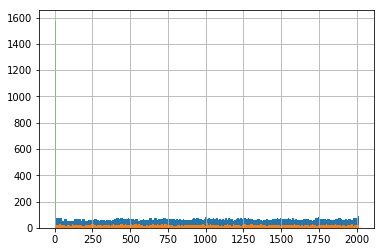

In [4]:
# Team name: Yog-Sothoth knows all...
# Eric Risbakk and Evelyn Hobert

import math
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PowerTransformer, StandardScaler, PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Dropout, Activation
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers
from keras.layers.normalization import BatchNormalization

# read data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
    
# train.head()
# train.describe()
# train.info()

# doing some quick analysis
# g = sns.PairGrid(train, y_vars=['cnt'], x_vars=train.drop(['cnt'], axis=1).columns.values, height=4)
# g.map(sns.regplot, x_jitter=0.1, scatter_kws={'alpha': 0.05})

# process data

# make dummy / one-hot variables
def one_hot(df, column):
    return pd.concat([df, pd.get_dummies(df[column], prefix=column, drop_first=False)], axis=1).drop([column], axis=1)

# make continuous variable into sin/cosine variables 
def make_circular(df, column, range):
    col_sin = df[column].apply(lambda x: math.sin(x * 2*math.pi / (range[-1]-range[0]+1)))
    col_cos = df[column].apply(lambda x: math.cos(x * 2*math.pi / (range[-1]-range[0]+1)))
    
    df[column+'_sin'] = col_sin
    df[column+'_cos'] = col_cos
    return df#.drop([column], axis=1)

# this lets us do all sortf of transformations to the data
def process_data(df):
    # process categorical data
#     df.season = df.season.astype('category', categories=[1, 2, 3, 4])
#     df.mnth = df.mnth.astype('category', categories=list(range(1, 12+1)))
#     df.hr = df.hr.astype('category', categories=list(range(0, 24)))
#     df.weekday = df.weekday.astype('category', categories=list(range(0, 7)))
    df.weathersit = df.weathersit.astype('category', categories=list(range(1, 4+1)))

#     but circular seems to work best for Random Forests
#     df = one_hot(df, 'season')
    df = make_circular(df, 'season', [1, 2, 3, 4])
#     df = one_hot(df, 'mnth')
    df = make_circular(df, 'mnth',list(range(1, 12+1)))
#     df = one_hot(df, 'hr')
    df = make_circular(df, 'hr', list(range(0, 24)))
#     df = one_hot(df, 'weekday')
    df = make_circular(df, 'weekday', list(range(0, 7)))
#     df = one_hot(df, 'weathersit')
    
    return df

# make a continuous time variable by combining hr, weekday and month
def time(df):
    return df.hr + df.weekday * 24 + (df.mnth-1) * 24 * 7
    
train['time'] = train.apply(time, axis=1)
test['time'] = test.apply(time, axis=1)

# plot some nice histograms to see the distribution of samples in time
train.time.hist(bins=200)
test.time.hist(bins=200)

full = process_data(train)
test = process_data(test)

full.describe()
full.info()
# train.head(n=20)

# make a validation set
train, vali = train_test_split(full, test_size=0.15, random_state=42)

# remove outliers
print(len(train))
# train = train[np.abs(train.cnt - train.cnt.mean()) <= (3 * train.cnt.std())] 
print(len(train))

# a log transformation makes the target values a lot more normal, but not quite.
full.cnt = full.cnt.astype(np.float64)
full.cnt.apply(lambda x: np.log1p(x)).hist(bins=20)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    8.2s finished
[Parallel(n_

training score:   0.9560996971530861


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


validation score: 0.8253623783072498


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s


training   RMSE:  38.37830418264571
validation RMSE:  75.32017708178368


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.3s finished
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights

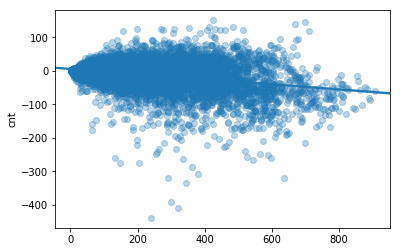

In [5]:
# add cnt of the closest neighbour as a new column
def weights(dist):
    mask = dist != 0
    w = np.zeros(dist.shape)
#     w[mask] = np.ones(dist.shape)[mask]
    w[mask] = np.reciprocal(dist[mask]+0.01)
#     print(dist)
#     print(w)
    return w+0.01

knn = KNeighborsRegressor(n_neighbors=3, weights=weights)
knn.fit(train.drop(['cnt'], axis=1)[['time', 'temp', 'hum']].values, np.log1p(train.cnt))
    
train['prev'] = knn.predict(train.drop(['cnt'], axis=1)[['time', 'temp', 'hum']].values)
vali['prev'] = knn.predict(vali.drop(['cnt'], axis=1)[['time', 'temp', 'hum']].values)

# vali.head()

# make all the datasets
X = train.drop(['cnt'], axis=1).values
y = train.cnt

X_vali = vali.drop(['cnt'], axis=1).values
y_vali = vali.cnt

X_full = full.drop(['cnt'], axis=1).values
y_full = full.cnt

# keras model, not used currently
def keras_model(optimizer='rmsprop', kernel_initializer='glorot_uniform', dropout=0.1):
    model = Sequential()
    model.add(Dense(200, activation='relu', kernel_initializer=kernel_initializer)) 
    model.add(Dropout(dropout))
    model.add(Dense(50, activation='relu', kernel_initializer=kernel_initializer))
#     model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(20, activation='relu', kernel_initializer=kernel_initializer))
#     model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='relu', kernel_initializer=kernel_initializer))

    model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy', 'mse'])
    return model

# wrap keras model into sklearn
keras_nn = KerasRegressor(build_fn=keras_model, epochs=100, batch_size=128)

# the pipeline allows us to easily change the model we use and chain different components if we want to
model = Pipeline([
#     ('norm', StandardScaler()),
#     ('trans', PowerTransformer()),
#     ('pca', PCA(0.999)),
#     ('poly', PolynomialFeatures(degree=2, interaction_only=False)),
#     ('linear', LinearRegression())
#     ('linear',  Lasso(alpha=0.1))
#     ('nn', MLPRegressor(activation='relu', solver='adam', learning_rate='adaptive', learning_rate_init=0.01, 
#                         hidden_layer_sizes=(100,20,), early_stopping=True, max_iter=1000, verbose=True))
#                         hidden_layer_sizes=(200,50,20,), early_stopping=True, max_iter=1000, verbose=True))
#     ('dt', DecisionTreeRegressor())
#     ('knn', KNeighborsRegressor(n_neighbors=3))
#     'max_features':np.arange(5,10),'n_estimators':[500],'min_samples_leaf': [10,50,100,200,500]
    ('rf', RandomForestRegressor(n_estimators=300, max_depth=None, max_features='auto', min_samples_leaf=2, verbose=True, n_jobs=4))
#     ('svm', SVR())
#     ('bayes', BayesianRidge())
#     ('keras', keras_nn)
])

# do the log scaling of the target values ('cnt')
model = TransformedTargetRegressor(regressor=model, func=np.log1p, inverse_func=np.expm1)
# model = TransformedTargetRegressor(regressor=model, func=np.sqrt, inverse_func=np.square)
# model = TransformedTargetRegressor(regressor=model, transformer=PowerTransformer(method='yeo-johnson'))

# and train the model!
model = model.fit(X, y)

# get some scores
print('training score:  ', model.score(X, y))
print('validation score:', model.score(X_vali, y_vali))
print('training   RMSE: ', math.sqrt(mean_squared_error(y, model.predict(X))))
print('validation RMSE: ', math.sqrt(mean_squared_error(y_vali, model.predict(X_vali))))

# plot residuals
sns.regplot(model.predict(X), model.predict(X) - y, scatter_kws={'alpha':0.3})

In [6]:
# re-fit on full dataset, for the final predictions
knn = KNeighborsRegressor(n_neighbors=3, weights=weights)
knn.fit(full.drop(['cnt'], axis=1)[['time', 'temp', 'hum']].values, full.cnt)
    
full['prev'] = knn.predict(full.drop(['cnt'], axis=1)[['time', 'temp', 'hum']].values)
test['prev'] = knn.predict(test[['time', 'temp', 'hum']].values)

X_full = full.drop(['cnt'], axis=1).values
y_full = full.cnt

model = model.fit(X_full, y_full)
print('training score:  ', model.score(X_full, y_full))

# predictions
pred = model.predict(test)

# and wrangle the output data into the right format for submissions
out = pd.DataFrame()
out['Id'] = range(1, len(test)+1)
out['cnt'] = list(map(lambda x: max(0,x), map(round, pred)))
out.head(n=10)
out.describe()
train.describe()

# and here we go, our final answer!
out.to_csv('output.csv', index=False)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    5.9s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    9.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


training score:   0.9583249212639221


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.1s finished
